<a href="https://colab.research.google.com/github/ailinwu520/Assignment-1/blob/main/DogsvsCatsKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.model_selection
import os
import torch
import skimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls ./drive/MyDrive/dogs-vs-cats

sampleSubmission.csv  test1.zip  train.zip


In [ ]:
!unzip ./drive/MyDrive/dogs-vs-cats/train.zip

Archive:  ./drive/MyDrive/dogs-vs-cats/train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip ./drive/MyDrive/dogs-vs-cats/test1.zip

Archive:  ./drive/MyDrive/dogs-vs-cats/test1.zip
replace test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

!ls ./train

(375, 499, 3)


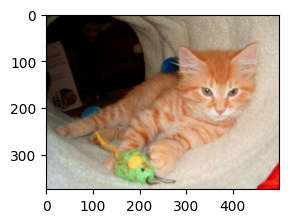

In [ ]:
# grab an image of a cat
i = np.random.randint(1000)
img = plt.imread(f'./train/cat.{i}.jpg')
print(img.shape)
plt.figure(figsize = (3, 3))
plt.imshow(img)

(224, 224, 3)


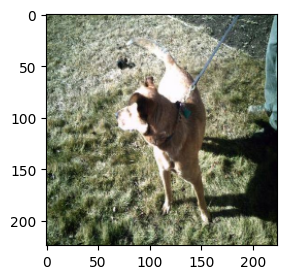

In [ ]:
# read the data
i = np.random.randint(1000)
img = plt.imread(f'./train/dog.{i}.jpg')
img = skimage.transform.resize(img, (224, 224)) # (row, column)
print(img.shape)
plt.figure(figsize = (3, 3))
plt.imshow(img)

In [ ]:
# all images have different shapes, so have to reshape
# distinguishing dogs or cats
# input different images
# output as label dog or cat
# CNN

# start using torch
fnames = os.listdir('./train')


In [ ]:
fnames[:10] # list of names

['cat.1163.jpg',
 'cat.10041.jpg',
 'dog.3381.jpg',
 'cat.1592.jpg',
 'cat.4169.jpg',
 'dog.4481.jpg',
 'dog.12301.jpg',
 'dog.12239.jpg',
 'dog.7591.jpg',
 'dog.9376.jpg']

In [ ]:
len(fnames) # 25000 names in the dataset

25000

In [ ]:
img2 = np.transpose(img, (2, 0, 1)) #depth comes first, instead of last(torch); depth comes last in matplotlib
img2.shape

(3, 224, 224)

In [ ]:
fnames = os.listdir('./train')
fnames_train, fnames_val = sk.model_selection.train_test_split(fnames, train_size=.8)

In [ ]:
# create dataset class
class DogVsCatDataset():
  def __init__(self, fnames):
    self.fnames = fnames

  def __len__(self):
    return len(self.fnames)

  def __getitem__(self, i):
    fname = self.fnames[i]
    img = plt.imread('./train/' + fname)
    img = skimage.transform.resize(img, (224, 224))
    img = np.transpose(img, (2, 0, 1))
    img = torch.tensor(img, dtype = torch.float32) # return as a torch tensor

    # get a label (either a 0 or 1); first three character of the file name
    if fname[0:3] == 'cat':
      label = 0
    else:
      label = 1

    label = torch.tensor(label, dtype = torch.float32)

    return img, label

dataset_train = DogVsCatDataset(fnames_train)
dataset_val = DogVsCatDataset(fnames_val)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 16, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 16, shuffle = False)

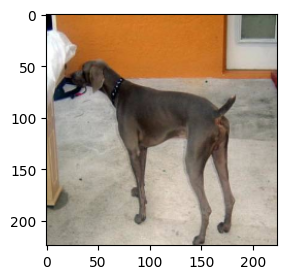

In [ ]:
# train dataset class
i = np.random.randint(len(dataset_train))
x, y = dataset_train.__getitem__(i)
x = np.transpose(x.numpy(), (1, 2, 0))
plt.figure(figsize = (3, 3))
plt.imshow(x)

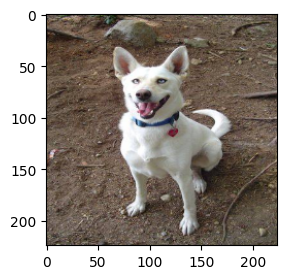

In [ ]:
# val dataset class
i = np.random.randint(len(dataset_val))
x, y = dataset_val.__getitem__(i)
x = np.transpose(x.numpy(), (1, 2, 0))
plt.figure(figsize = (3, 3))
plt.imshow(x)

In [ ]:
# dataloader
x_batch, y_batch = next(iter(dataloader_train))

In [ ]:
# NN class
class SimpleCNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 3, padding = 'same')
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 'same')
    self.dense1 = torch.nn.Linear(64*112*112, 1) # binary class is 1

    self.relu = torch.nn.ReLU()
    self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.conv1(x) # x has the shape of (32, 224, 224)
    x = self.relu(x)
    x = self.maxpool(x) # x has the shape of (32, 112, 112)

    x = self.conv2(x) # x has the shape of (64, 112, 112)
    x = self.relu(x)
    # x = self.maxpool(x) # x has the shape of (64, 112, 112)

    x = torch.flatten(x, start_dim = 1) # x has the shape of 64*112*112
    x = self.dense1(x)

    return x

In [ ]:
torch.cuda.is_available()

False

In [ ]:
# model = SimpleCNN() # instence of our class
# device = torch.device('cuda')
# device = torch.device('cpu')
# model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dense1): Linear(in_features=802816, out_features=1, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
import torchvision # instead of using our own model, we use resnet

model = torchvision.models.resent18(pretrained = True)
for param in model.parameters():
  param.requires_grad = False
model.fc = toch.nn.Linear(512, 1) # the final layer in model
# put model in Gpu

device = torch.device('cpu')
model.to(device)


In [ ]:
for param in model.parameters():
  print(param.is_cuda)

In [ ]:
for param in model.parameters():
  print(param.requires_grad) # last two entries are True

In [ ]:
# free the NN parameter, so they dont change: model
# only change the model.fc
# model
# model.fc.parameters()

# pretrained model ML in the real world

In [ ]:
# binary classification
# train model
loss_fun = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)


In [ ]:
y_batch.unsqueeze(1).shape

In [ ]:
num_epochs = 5
ace_train_val = []
for ep in range(num_epochs):
  for x_batch, y_batch in dataloader_train:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    outputs = model(x_batch)
    loss = loss_fun(outputs, y_batch.unsqueeze(1))
    model.zero_grad()
    loss.backward()

  ace_train = 0
  with torch.no_grad():
    for x_batch, y_batch in dataloader_train:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(x_batch)
      loss = loss_fun(outputs, y_batch.unsqueeze(1))
      ace_train += loss * len(y_batch)

    ace_train = ace_train.item() / len(dataset_train)
    ace_train_val.append(ace_train)
    print(f'ace_train is: ', ace_train)


ace_train is:  0.693099267578125
ace_train is:  0.69309873046875


In [ ]:
# a bacth to NN
y_pred = model(x_batch)

In [ ]:
y_pred.shape # 16 images output of NN